## 1. Importação de Bibliotecas

In [53]:
# Instalar XGBoost se necessário
%pip install xgboost --quiet

Note: you may need to restart the kernel to use updated packages.


In [54]:
# Bibliotecas essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os

# Modelos supervisionados
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Pré-processamento e métricas
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Cores para visualizações
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Seed para reprodutibilidade
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [55]:
# Definir constantes
TARGET_COL = 'PotActiva'
POINTS_PER_DAY = 96  # 4 leituras por hora × 24 horas
POINTS_PER_WEEK = POINTS_PER_DAY * 7  # 672 pontos por semana

print(f"Variável alvo: {TARGET_COL}")
print(f"Pontos por dia: {POINTS_PER_DAY}")
print(f"Pontos por semana: {POINTS_PER_WEEK}")

Variável alvo: PotActiva
Pontos por dia: 96
Pontos por semana: 672


## 2. Carregamento dos Dados

In [56]:
# Carregar séries temporais e splits
print("A carregar dados...")

df_series = pd.read_csv('data/intermediate/d4maia_series_per_cpe.csv')
df_series['tstamp'] = pd.to_datetime(df_series['tstamp'])

df_split = pd.read_csv('data/intermediate/d4maia_ts_train_test_index.csv')
df_split['split_timestamp'] = pd.to_datetime(df_split['split_timestamp'])

# Carregar resultados de séries temporais para comparação
df_ts_results = pd.read_csv('data/intermediate/d4maia_ts_results.csv')

print(f"\nSéries temporais: {len(df_series):,} registos, {df_series['CPE'].nunique()} CPEs")
print(f"Splits definidos: {len(df_split)} CPEs")
print(f"Resultados de séries temporais: {len(df_ts_results)} entradas")

A carregar dados...

Séries temporais: 5,838,256 registos, 89 CPEs
Splits definidos: 89 CPEs
Resultados de séries temporais: 15 entradas

Séries temporais: 5,838,256 registos, 89 CPEs
Splits definidos: 89 CPEs
Resultados de séries temporais: 15 entradas


In [57]:
# Selecionar os mesmos CPEs usados no notebook 04 para comparação justa
cpe_counts = df_series.groupby('CPE').size().sort_values(ascending=False)
N_CPES = 5
selected_cpes = cpe_counts.head(N_CPES).index.tolist()

print(f"CPEs selecionados para análise ({N_CPES}):")
for i, cpe in enumerate(selected_cpes, 1):
    n_registos = cpe_counts[cpe]
    print(f"  {i}. {cpe}: {n_registos:,} registos")

CPEs selecionados para análise (5):
  1. PT0002000068856781NM: 81,776 registos
  2. PT0002000068856906VS: 81,776 registos
  3. PT0002000081997398TD: 81,774 registos
  4. PT0002000073231742VK: 81,773 registos
  5. PT0002000033074862LZ: 81,772 registos


## 3. Construção de Features para Modelos Supervisionados

**Regra importante:** Todas as features usadas para prever um instante têm de ser calculadas com dados de pelo menos **uma semana antes** desse instante.

### Estratégia:
- Para cada ponto no tempo `t`, criar features baseadas nos dados até `t - 1 semana`
- Target: consumo médio da semana seguinte (ou valor específico)

In [58]:
def create_supervised_features(df_cpe, target_col=TARGET_COL, lookback_weeks=1):
    """
    Cria features supervisionadas para um CPE.
    
    Para cada semana, cria features baseadas nas semanas anteriores
    e define o target como o consumo médio da semana seguinte.
    
    Args:
        df_cpe: DataFrame com dados de um CPE (ordenado por tstamp)
        target_col: coluna alvo
        lookback_weeks: número de semanas a usar para criar features
    
    Returns:
        DataFrame com features e target
    """
    df = df_cpe.sort_values('tstamp').copy()
    df = df.reset_index(drop=True)
    
    # Adicionar colunas temporais se não existirem
    if 'hora' not in df.columns:
        df['hora'] = df['tstamp'].dt.hour
    if 'dia_semana' not in df.columns:
        df['dia_semana'] = df['tstamp'].dt.dayofweek
    
    features_list = []
    
    # Processar por semanas
    # Começar a partir de lookback_weeks + 1 semanas para ter dados suficientes
    start_idx = POINTS_PER_WEEK * (lookback_weeks + 1)
    
    # Criar uma amostra por semana (para não ter demasiados pontos)
    week_starts = list(range(start_idx, len(df) - POINTS_PER_WEEK, POINTS_PER_WEEK))
    
    for week_start in week_starts:
        # Dados para criar features (semana(s) anterior(es))
        feature_end = week_start
        feature_start = max(0, feature_end - POINTS_PER_WEEK * lookback_weeks)
        df_features = df.iloc[feature_start:feature_end]
        
        # Dados target (semana seguinte)
        target_start = week_start
        target_end = min(week_start + POINTS_PER_WEEK, len(df))
        df_target = df.iloc[target_start:target_end]
        
        if len(df_features) < POINTS_PER_DAY or len(df_target) < POINTS_PER_DAY:
            continue
        
        # Criar features
        features = {}
        
        # Estatísticas gerais da semana anterior
        features['prev_mean'] = df_features[target_col].mean()
        features['prev_std'] = df_features[target_col].std()
        features['prev_min'] = df_features[target_col].min()
        features['prev_max'] = df_features[target_col].max()
        features['prev_median'] = df_features[target_col].median()
        features['prev_q25'] = df_features[target_col].quantile(0.25)
        features['prev_q75'] = df_features[target_col].quantile(0.75)
        
        # Coeficiente de variação
        if features['prev_mean'] > 0:
            features['prev_cv'] = features['prev_std'] / features['prev_mean']
        else:
            features['prev_cv'] = 0
        
        # Consumo por período do dia
        for hora in [0, 6, 12, 18]:
            mask = (df_features['hora'] >= hora) & (df_features['hora'] < hora + 6)
            features[f'prev_mean_h{hora:02d}_{hora+6:02d}'] = df_features.loc[mask, target_col].mean()
        
        # Consumo por dia da semana
        dias_nome = ['seg', 'ter', 'qua', 'qui', 'sex', 'sab', 'dom']
        for dia in range(7):
            mask = df_features['dia_semana'] == dia
            features[f'prev_mean_{dias_nome[dia]}'] = df_features.loc[mask, target_col].mean()
        
        # Tendência (diferença entre segunda e primeira metade)
        mid_point = len(df_features) // 2
        first_half = df_features.iloc[:mid_point][target_col].mean()
        second_half = df_features.iloc[mid_point:][target_col].mean()
        features['prev_trend'] = second_half - first_half
        
        # Pico e vale
        consumo_por_hora = df_features.groupby('hora')[target_col].mean()
        features['prev_hora_pico'] = consumo_por_hora.idxmax()
        features['prev_hora_vale'] = consumo_por_hora.idxmin()
        features['prev_valor_pico'] = consumo_por_hora.max()
        features['prev_valor_vale'] = consumo_por_hora.min()
        
        # Rácio pico/vale
        if features['prev_valor_vale'] > 0:
            features['prev_racio_pico_vale'] = features['prev_valor_pico'] / features['prev_valor_vale']
        else:
            features['prev_racio_pico_vale'] = 1
        
        # Fim de semana vs dias úteis
        mask_weekend = df_features['dia_semana'] >= 5
        mask_weekday = df_features['dia_semana'] < 5
        mean_weekend = df_features.loc[mask_weekend, target_col].mean() if mask_weekend.sum() > 0 else 0
        mean_weekday = df_features.loc[mask_weekday, target_col].mean() if mask_weekday.sum() > 0 else 0
        features['prev_mean_weekend'] = mean_weekend
        features['prev_mean_weekday'] = mean_weekday
        if mean_weekday > 0:
            features['prev_racio_weekend'] = mean_weekend / mean_weekday
        else:
            features['prev_racio_weekend'] = 1
        
        # Target: consumo médio da semana seguinte
        features['target'] = df_target[target_col].mean()
        features['target_std'] = df_target[target_col].std()
        
        # Timestamp de referência
        features['ref_timestamp'] = df.iloc[week_start]['tstamp']
        
        features_list.append(features)
    
    return pd.DataFrame(features_list)


print("Função de criação de features definida.")

Função de criação de features definida.


In [59]:
# Criar dataset supervisionado para todos os CPEs
print("Criando dataset supervisionado...")
print("=" * 60)

all_features = []

for i, cpe in enumerate(selected_cpes, 1):
    print(f"[{i}/{len(selected_cpes)}] {cpe}...", end=" ")
    
    df_cpe = df_series[df_series['CPE'] == cpe].copy()
    df_feat = create_supervised_features(df_cpe)
    df_feat['CPE'] = cpe
    
    all_features.append(df_feat)
    print(f"{len(df_feat)} amostras")

df_supervised = pd.concat(all_features, ignore_index=True)

print(f"\nDataset supervisionado criado:")
print(f"  Total de amostras: {len(df_supervised)}")
print(f"  Features: {len(df_supervised.columns) - 3}")

Criando dataset supervisionado...
[1/5] PT0002000068856781NM... 119 amostras
[2/5] PT0002000068856906VS... 119 amostras
[2/5] PT0002000068856906VS... 119 amostras
[3/5] PT0002000081997398TD... 119 amostras
[3/5] PT0002000081997398TD... 119 amostras
[4/5] PT0002000073231742VK... 119 amostras
[4/5] PT0002000073231742VK... 119 amostras
[5/5] PT0002000033074862LZ... 119 amostras
[5/5] PT0002000033074862LZ... 119 amostras

Dataset supervisionado criado:
  Total de amostras: 595
  Features: 29
119 amostras

Dataset supervisionado criado:
  Total de amostras: 595
  Features: 29


In [60]:
# Visualizar dataset
df_supervised.head(10)

,prev_mean,prev_std,prev_min,prev_max,prev_median,prev_q25,prev_q75,prev_cv,prev_mean_h00_06,prev_mean_h06_12,prev_mean_h12_18,prev_mean_h18_24,prev_mean_seg,prev_mean_ter,prev_mean_qua,prev_mean_qui,prev_mean_sex,prev_mean_sab,prev_mean_dom,prev_trend,prev_hora_pico,prev_hora_vale,prev_valor_pico,prev_valor_vale,prev_racio_pico_vale,prev_mean_weekend,prev_mean_weekday,prev_racio_weekend,target,target_std,ref_timestamp,CPE
0,32.2128,2.3787,30.0000,40.0000,31.0000,30.0000,34.0000,0.0738,30.9345,32.5893,34.1905,31.1369,33.1250,33.5417,32.7708,32.9375,32.4271,30.3750,30.3125,1.3601,12,5,34.7143,30.8214,1.1263,30.3438,32.9604,0.9206,32.8631,2.6164,2023-01-14 00:15:00,PT0002000068856781NM
1,32.8631,2.6164,30.0000,40.0000,32.0000,31.0000,35.0000,0.0796,31.4643,33.3810,34.9821,31.6250,33.4792,33.5521,33.7083,34.3958,33.4375,30.7812,30.6875,2.1429,12,5,35.6786,31.2857,1.1404,30.7344,33.7146,0.9116,32.7113,2.4078,2023-01-21 00:15:00,PT0002000068856781NM
2,32.7113,2.4078,30.0000,39.0000,32.0000,31.0000,34.0000,0.0736,31.5417,33.1071,34.4702,31.7262,33.0104,33.8646,33.9062,33.9896,33.4271,30.4792,30.3021,2.2857,10,7,35.0000,31.4286,1.1136,30.3906,33.6396,0.9034,32.6429,2.4798,2023-01-28 00:15:00,PT0002000068856781NM
3,32.6429,2.4798,29.0000,40.0000,32.0000,30.0000,34.0000,0.0760,31.5060,33.1607,34.1488,31.7560,33.3958,34.1979,34.0312,33.3333,33.1771,30.1771,30.1875,2.0179,11,6,35.5357,31.4286,1.1307,30.1823,33.6271,0.8976,32.2455,1.7994,2023-02-04 00:15:00,PT0002000068856781NM
4,32.2455,1.7994,29.0000,38.0000,32.0000,31.0000,33.0000,0.0558,31.3393,32.5655,33.9345,31.1429,32.9271,32.3125,32.6042,32.0938,31.3542,32.2396,32.1875,-0.3720,14,23,34.5000,30.9643,1.1142,32.2135,32.2583,0.9986,31.2708,2.0077,2023-02-11 00:15:00,PT0002000068856781NM
5,31.2708,2.0077,29.0000,38.0000,30.0000,30.0000,32.0000,0.0642,30.1786,31.4762,33.0298,30.3988,32.0417,32.0208,31.7500,31.6250,31.9271,29.8750,29.6562,1.1607,12,6,33.4643,30.0357,1.1141,29.7656,31.8729,0.9339,31.4330,1.7130,2023-02-18 00:15:00,PT0002000068856781NM
6,31.4330,1.7130,29.0000,38.0000,31.0000,30.0000,33.0000,0.0545,30.7619,31.4286,32.6310,30.9107,31.7500,30.4792,31.7604,32.6042,32.5729,30.2292,30.6354,1.3423,15,8,33.1071,30.5000,1.0855,30.4323,31.8333,0.9560,32.3408,2.3694,2023-02-25 00:15:00,PT0002000068856781NM
7,32.3408,2.3694,30.0000,39.0000,32.0000,30.0000,34.0000,0.0733,31.2560,32.6667,34.0357,31.4048,33.0729,34.2188,33.8333,32.8646,31.9479,30.2500,30.1979,1.6042,11,6,34.8571,31.1429,1.1193,30.2240,33.1875,0.9107,31.3750,1.8448,2023-03-04 00:15:00,PT0002000068856781NM
8,31.3750,1.8448,29.0000,38.0000,31.0000,30.0000,32.0000,0.0588,30.3452,31.5298,33.1667,30.4583,31.8125,32.0938,32.1250,31.8333,31.4271,30.1771,30.1562,1.0655,15,6,33.7857,30.2143,1.1182,30.1667,31.8583,0.9469,30.8140,1.9115,2023-03-11 00:15:00,PT0002000068856781NM
9,30.8140,1.9115,29.0000,37.0000,30.0000,29.0000,32.0000,0.0620,29.7143,30.9702,32.6071,29.9643,31.4479,31.8646,31.3021,31.1250,31.0521,29.5521,29.3542,0.9673,15,7,33.1429,29.6071,1.1194,29.4531,31.3583,0.9392,31.0149,2.1271,2023-03-18 00:15:00,PT0002000068856781NM


In [61]:
# Estatísticas do target
print("Estatísticas do target (consumo médio semanal):")
print(df_supervised['target'].describe())

Estatísticas do target (consumo médio semanal):
count   595.0000
mean     15.3733
std      12.2032
min       2.3021
25%       5.4360
50%       7.3438
75%      28.9717
max      56.0551
Name: target, dtype: float64


## 4. Preparação dos Dados para Treino/Teste

In [62]:
def prepare_train_test(df_supervised, df_split, cpe):
    """
    Prepara dados de treino e teste para um CPE específico.
    Usa o mesmo split temporal definido no notebook 02.
    """
    # Filtrar dados do CPE
    df_cpe = df_supervised[df_supervised['CPE'] == cpe].copy()
    
    # Obter timestamp de split
    split_info = df_split[df_split['CPE'] == cpe]
    if len(split_info) > 0:
        split_ts = pd.to_datetime(split_info['split_timestamp'].values[0])
    else:
        # Usar 70% se não definido
        n_train = int(len(df_cpe) * 0.7)
        split_ts = df_cpe.iloc[n_train]['ref_timestamp']
    
    # Dividir
    train = df_cpe[df_cpe['ref_timestamp'] <= split_ts]
    test = df_cpe[df_cpe['ref_timestamp'] > split_ts]
    
    return train, test


# Definir colunas de features (excluir target, CPE, timestamps)
exclude_cols = ['target', 'target_std', 'CPE', 'ref_timestamp']
feature_cols = [col for col in df_supervised.columns if col not in exclude_cols]

print(f"Colunas de features: {len(feature_cols)}")
print(f"\nFeatures:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

Colunas de features: 28

Features:
   1. prev_mean
   2. prev_std
   3. prev_min
   4. prev_max
   5. prev_median
   6. prev_q25
   7. prev_q75
   8. prev_cv
   9. prev_mean_h00_06
  10. prev_mean_h06_12
  11. prev_mean_h12_18
  12. prev_mean_h18_24
  13. prev_mean_seg
  14. prev_mean_ter
  15. prev_mean_qua
  16. prev_mean_qui
  17. prev_mean_sex
  18. prev_mean_sab
  19. prev_mean_dom
  20. prev_trend
  21. prev_hora_pico
  22. prev_hora_vale
  23. prev_valor_pico
  24. prev_valor_vale
  25. prev_racio_pico_vale
  26. prev_mean_weekend
  27. prev_mean_weekday
  28. prev_racio_weekend


## 5. Funções de Treino e Avaliação

In [63]:
def calculate_metrics(y_true, y_pred):
    """Calcula MAE, RMSE e MAPE."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # MAPE
    mask = y_true != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}


def train_and_evaluate(X_train, y_train, X_test, y_test, model, model_name, use_cv=False):
    """
    Treina um modelo e avalia no conjunto de teste.
    Adiciona validação cruzada opcional.
    """
    try:
        if use_cv:
            # Usar validação cruzada para melhor avaliação
            from sklearn.model_selection import cross_val_score
            cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_absolute_error')
            cv_mae = -cv_scores.mean()
            print(f"    CV MAE: {cv_mae:.3f}")
        else:
            cv_mae = None
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        metrics = calculate_metrics(y_test, y_pred)
        
        if use_cv:
            metrics['cv_mae'] = cv_mae
            
        return metrics, y_pred, True
    except Exception as e:
        print(f"    Erro {model_name}: {str(e)[:50]}")
        return None, None, False


print("Funções de treino e avaliação definidas.")

Funções de treino e avaliação definidas.


## 6. Baseline: Semana Anterior

A baseline para este problema é usar o consumo médio da semana anterior como previsão.

In [64]:
# Calcular baseline para todos os CPEs
baseline_results = []

print("Calculando baseline (média da semana anterior):")
print("=" * 60)

for cpe in selected_cpes:
    train, test = prepare_train_test(df_supervised, df_split, cpe)
    
    if len(test) == 0:
        print(f"  {cpe}: Sem dados de teste")
        continue
    
    # Baseline: usar prev_mean como previsão
    y_true = test['target'].values
    y_pred = test['prev_mean'].values
    
    metrics = calculate_metrics(y_true, y_pred)
    
    baseline_results.append({
        'CPE': cpe,
        'model': 'Baseline',
        'normalized': 'N/A',
        'MAE': metrics['MAE'],
        'RMSE': metrics['RMSE'],
        'MAPE': metrics['MAPE'],
        'n_test': len(y_true)
    })
    
    print(f"  {cpe[:25]}...: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}")

print("\nConcluído!")

Calculando baseline (média da semana anterior):
  PT0002000068856781NM...: MAE=0.3862, RMSE=0.5297
  PT0002000068856906VS...: MAE=0.9196, RMSE=1.1354
  PT0002000081997398TD...: MAE=2.6758, RMSE=3.9958
  PT0002000073231742VK...: MAE=0.4946, RMSE=0.7018
  PT0002000033074862LZ...: MAE=0.9458, RMSE=1.4758

Concluído!


## 7. Random Forest

In [65]:
# Random Forest - SEM normalização
rf_results_raw = []

print("Random Forest - SEM normalização:")
print("=" * 60)

for cpe in selected_cpes:
    train, test = prepare_train_test(df_supervised, df_split, cpe)
    
    if len(test) == 0 or len(train) < 5:
        print(f"  {cpe}: Dados insuficientes")
        continue
    
    X_train = train[feature_cols].values
    y_train = train['target'].values
    X_test = test[feature_cols].values
    y_test = test['target'].values
    
    # Treinar modelo - MELHORADO
    model = RandomForestRegressor(
        n_estimators=200, 
        max_depth=15, 
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=RANDOM_STATE, 
        n_jobs=-1
    )
    metrics, y_pred, success = train_and_evaluate(X_train, y_train, X_test, y_test, model, 'RF')
    
    if success:
        rf_results_raw.append({
            'CPE': cpe,
            'model': 'RF',
            'normalized': 'No',
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'MAPE': metrics['MAPE'],
            'n_test': len(y_test)
        })
        print(f"  {cpe[:25]}...: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}")

print("\nConcluído!")

Random Forest - SEM normalização:
  PT0002000068856781NM...: MAE=0.3974, RMSE=0.5258
  PT0002000068856906VS...: MAE=0.8993, RMSE=1.0711
  PT0002000081997398TD...: MAE=3.2351, RMSE=4.1388
  PT0002000068856906VS...: MAE=0.8993, RMSE=1.0711
  PT0002000081997398TD...: MAE=3.2351, RMSE=4.1388
  PT0002000073231742VK...: MAE=0.5265, RMSE=0.6764
  PT0002000033074862LZ...: MAE=0.9843, RMSE=1.3914

Concluído!
  PT0002000073231742VK...: MAE=0.5265, RMSE=0.6764
  PT0002000033074862LZ...: MAE=0.9843, RMSE=1.3914

Concluído!


In [66]:
# Random Forest - COM normalização (StandardScaler)
rf_results_norm = []

print("Random Forest - COM normalização (StandardScaler):")
print("=" * 60)

for cpe in selected_cpes:
    train, test = prepare_train_test(df_supervised, df_split, cpe)
    
    if len(test) == 0 or len(train) < 5:
        continue
    
    X_train = train[feature_cols].values
    y_train = train['target'].values
    X_test = test[feature_cols].values
    y_test = test['target'].values
    
    # Normalizar
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Treinar modelo - MELHORADO
    model = RandomForestRegressor(
        n_estimators=200, 
        max_depth=15, 
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=RANDOM_STATE, 
        n_jobs=-1
    )
    metrics, y_pred, success = train_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test, model, 'RF')
    
    if success:
        rf_results_norm.append({
            'CPE': cpe,
            'model': 'RF',
            'normalized': 'Yes',
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'MAPE': metrics['MAPE'],
            'n_test': len(y_test)
        })
        print(f"  {cpe[:25]}...: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}")

print("\nConcluído!")

Random Forest - COM normalização (StandardScaler):
  PT0002000068856781NM...: MAE=0.3984, RMSE=0.5262
  PT0002000068856906VS...: MAE=0.8979, RMSE=1.0702
  PT0002000068856781NM...: MAE=0.3984, RMSE=0.5262
  PT0002000068856906VS...: MAE=0.8979, RMSE=1.0702
  PT0002000081997398TD...: MAE=3.2413, RMSE=4.1461
  PT0002000073231742VK...: MAE=0.5277, RMSE=0.6773
  PT0002000081997398TD...: MAE=3.2413, RMSE=4.1461
  PT0002000073231742VK...: MAE=0.5277, RMSE=0.6773
  PT0002000033074862LZ...: MAE=0.9833, RMSE=1.3908

Concluído!
  PT0002000033074862LZ...: MAE=0.9833, RMSE=1.3908

Concluído!


## 8. XGBoost

In [67]:
# XGBoost - SEM normalização
xgb_results_raw = []

print("XGBoost - SEM normalização:")
print("=" * 60)

for cpe in selected_cpes:
    train, test = prepare_train_test(df_supervised, df_split, cpe)
    
    if len(test) == 0 or len(train) < 5:
        continue
    
    X_train = train[feature_cols].values
    y_train = train['target'].values
    X_test = test[feature_cols].values
    y_test = test['target'].values
    
    # Treinar modelo - MELHORADO
    model = XGBRegressor(
        n_estimators=200, 
        max_depth=8, 
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE, 
        verbosity=0
    )
    metrics, y_pred, success = train_and_evaluate(X_train, y_train, X_test, y_test, model, 'XGB')
    
    if success:
        xgb_results_raw.append({
            'CPE': cpe,
            'model': 'XGBoost',
            'normalized': 'No',
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'MAPE': metrics['MAPE'],
            'n_test': len(y_test)
        })
        print(f"  {cpe[:25]}...: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}")

print("\nConcluído!")

XGBoost - SEM normalização:
  PT0002000068856781NM...: MAE=0.5096, RMSE=0.6212
  PT0002000068856906VS...: MAE=0.8976, RMSE=1.0687
  PT0002000081997398TD...: MAE=4.1462, RMSE=5.2900
  PT0002000073231742VK...: MAE=0.5508, RMSE=0.7375
  PT0002000068856906VS...: MAE=0.8976, RMSE=1.0687
  PT0002000081997398TD...: MAE=4.1462, RMSE=5.2900
  PT0002000073231742VK...: MAE=0.5508, RMSE=0.7375
  PT0002000033074862LZ...: MAE=1.0964, RMSE=1.4635

Concluído!
  PT0002000033074862LZ...: MAE=1.0964, RMSE=1.4635

Concluído!


In [68]:
# XGBoost - COM normalização
xgb_results_norm = []

print("XGBoost - COM normalização (StandardScaler):")
print("=" * 60)

for cpe in selected_cpes:
    train, test = prepare_train_test(df_supervised, df_split, cpe)
    
    if len(test) == 0 or len(train) < 5:
        continue
    
    X_train = train[feature_cols].values
    y_train = train['target'].values
    X_test = test[feature_cols].values
    y_test = test['target'].values
    
    # Normalizar
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Treinar modelo - MELHORADO
    model = XGBRegressor(
        n_estimators=200, 
        max_depth=8, 
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE, 
        verbosity=0
    )
    metrics, y_pred, success = train_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test, model, 'XGB')
    
    if success:
        xgb_results_norm.append({
            'CPE': cpe,
            'model': 'XGBoost',
            'normalized': 'Yes',
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'MAPE': metrics['MAPE'],
            'n_test': len(y_test)
        })
        print(f"  {cpe[:25]}...: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}")

print("\nConcluído!")

XGBoost - COM normalização (StandardScaler):
  PT0002000068856781NM...: MAE=0.5096, RMSE=0.6212
  PT0002000068856906VS...: MAE=0.8976, RMSE=1.0687
  PT0002000081997398TD...: MAE=4.1462, RMSE=5.2900
  PT0002000068856906VS...: MAE=0.8976, RMSE=1.0687
  PT0002000081997398TD...: MAE=4.1462, RMSE=5.2900
  PT0002000073231742VK...: MAE=0.5508, RMSE=0.7375
  PT0002000033074862LZ...: MAE=1.0964, RMSE=1.4635

Concluído!
  PT0002000073231742VK...: MAE=0.5508, RMSE=0.7375
  PT0002000033074862LZ...: MAE=1.0964, RMSE=1.4635

Concluído!


## 9. MLP (Multi-Layer Perceptron)

In [69]:
# MLP - SEM normalização (não recomendado para MLP)
mlp_results_raw = []

print("MLP - SEM normalização:")
print("=" * 60)

for cpe in selected_cpes:
    train, test = prepare_train_test(df_supervised, df_split, cpe)
    
    if len(test) == 0 or len(train) < 5:
        continue
    
    X_train = train[feature_cols].values
    y_train = train['target'].values
    X_test = test[feature_cols].values
    y_test = test['target'].values
    
    # Treinar modelo - MELHORADO
    model = MLPRegressor(
        hidden_layer_sizes=(128, 64, 32), 
        max_iter=1000, 
        learning_rate_init=0.001,
        alpha=0.001,
        random_state=RANDOM_STATE, 
        early_stopping=True,
        validation_fraction=0.2
    )
    metrics, y_pred, success = train_and_evaluate(X_train, y_train, X_test, y_test, model, 'MLP')
    
    if success:
        mlp_results_raw.append({
            'CPE': cpe,
            'model': 'MLP',
            'normalized': 'No',
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'MAPE': metrics['MAPE'],
            'n_test': len(y_test)
        })
        print(f"  {cpe[:25]}...: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}")

print("\nConcluído!")

MLP - SEM normalização:
  PT0002000068856781NM...: MAE=0.4537, RMSE=0.6170
  PT0002000068856906VS...: MAE=0.8929, RMSE=1.1566
  PT0002000081997398TD...: MAE=2.4174, RMSE=3.7868
  PT0002000068856906VS...: MAE=0.8929, RMSE=1.1566
  PT0002000081997398TD...: MAE=2.4174, RMSE=3.7868
  PT0002000073231742VK...: MAE=0.4822, RMSE=0.6318
  PT0002000033074862LZ...: MAE=0.9663, RMSE=1.4046

Concluído!
  PT0002000073231742VK...: MAE=0.4822, RMSE=0.6318
  PT0002000033074862LZ...: MAE=0.9663, RMSE=1.4046

Concluído!


In [70]:
# MLP - COM normalização (recomendado)
mlp_results_norm = []

print("MLP - COM normalização (StandardScaler):")
print("=" * 60)

for cpe in selected_cpes:
    train, test = prepare_train_test(df_supervised, df_split, cpe)
    
    if len(test) == 0 or len(train) < 5:
        continue
    
    X_train = train[feature_cols].values
    y_train = train['target'].values
    X_test = test[feature_cols].values
    y_test = test['target'].values
    
    # Normalizar features E target para MLP
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
    
    # Treinar modelo - MELHORADO
    model = MLPRegressor(
        hidden_layer_sizes=(128, 64, 32), 
        max_iter=1000, 
        learning_rate_init=0.001,
        alpha=0.001,
        random_state=RANDOM_STATE, 
        early_stopping=True,
        validation_fraction=0.2
    )
    
    try:
        model.fit(X_train_scaled, y_train_scaled)
        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        
        metrics = calculate_metrics(y_test, y_pred)
        
        mlp_results_norm.append({
            'CPE': cpe,
            'model': 'MLP',
            'normalized': 'Yes',
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'MAPE': metrics['MAPE'],
            'n_test': len(y_test)
        })
        print(f"  {cpe[:25]}...: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}")
    except Exception as e:
        print(f"  {cpe[:25]}...: Erro - {str(e)[:30]}")

print("\nConcluído!")

MLP - COM normalização (StandardScaler):
  PT0002000068856781NM...: MAE=0.8113, RMSE=0.9259
  PT0002000068856906VS...: MAE=0.9948, RMSE=1.2289
  PT0002000081997398TD...: MAE=3.5191, RMSE=4.8792
  PT0002000073231742VK...: MAE=0.4980, RMSE=0.6711
  PT0002000033074862LZ...: MAE=0.9138, RMSE=1.2732

Concluído!
  PT0002000073231742VK...: MAE=0.4980, RMSE=0.6711
  PT0002000033074862LZ...: MAE=0.9138, RMSE=1.2732

Concluído!


## 10. Comparação de Resultados

In [71]:
# Juntar todos os resultados
all_results = (baseline_results + 
               rf_results_raw + rf_results_norm + 
               xgb_results_raw + xgb_results_norm + 
               mlp_results_raw + mlp_results_norm)

df_results = pd.DataFrame(all_results)

print("Todos os resultados:")
print("=" * 100)
print(df_results.to_string(index=False))

Todos os resultados:
                 CPE    model normalized    MAE   RMSE    MAPE  n_test
PT0002000068856781NM Baseline        N/A 0.3862 0.5297  1.2676      35
PT0002000068856906VS Baseline        N/A 0.9196 1.1354 16.1260      35
PT0002000081997398TD Baseline        N/A 2.6758 3.9958  8.3158      35
PT0002000073231742VK Baseline        N/A 0.4946 0.7018 10.7034      35
PT0002000033074862LZ Baseline        N/A 0.9458 1.4758 13.9696      35
PT0002000068856781NM       RF         No 0.3974 0.5258  1.3087      35
PT0002000068856906VS       RF         No 0.8993 1.0711 16.2958      35
PT0002000081997398TD       RF         No 3.2351 4.1388 10.5530      35
PT0002000073231742VK       RF         No 0.5265 0.6764 11.4146      35
PT0002000033074862LZ       RF         No 0.9843 1.3914 13.5006      35
PT0002000068856781NM       RF        Yes 0.3984 0.5262  1.3119      35
PT0002000068856906VS       RF        Yes 0.8979 1.0702 16.2800      35
PT0002000081997398TD       RF        Yes 3.2413 4.1461 1

In [72]:
# Estatísticas agregadas por modelo e normalização
print("\nEstatísticas agregadas por modelo:")
print("=" * 80)

stats = df_results.groupby(['model', 'normalized']).agg({
    'MAE': ['mean', 'std'],
    'RMSE': ['mean', 'std'],
    'CPE': 'count'
}).round(4)

stats.columns = ['MAE_mean', 'MAE_std', 'RMSE_mean', 'RMSE_std', 'n_CPEs']
print(stats.to_string())


Estatísticas agregadas por modelo:
                     MAE_mean  MAE_std  RMSE_mean  RMSE_std  n_CPEs
model    normalized                                                
Baseline N/A           1.0844   0.9239     1.5677    1.4070       5
MLP      No            1.0425   0.8030     1.5194    1.3123       5
         Yes           1.3474   1.2286     1.7957    1.7410       5
RF       No            1.2085   1.1593     1.5607    1.4806       5
         Yes           1.2097   1.1618     1.5621    1.4836       5
XGBoost  No            1.4401   1.5323     1.8362    1.9583       5
         Yes           1.4401   1.5323     1.8362    1.9583       5


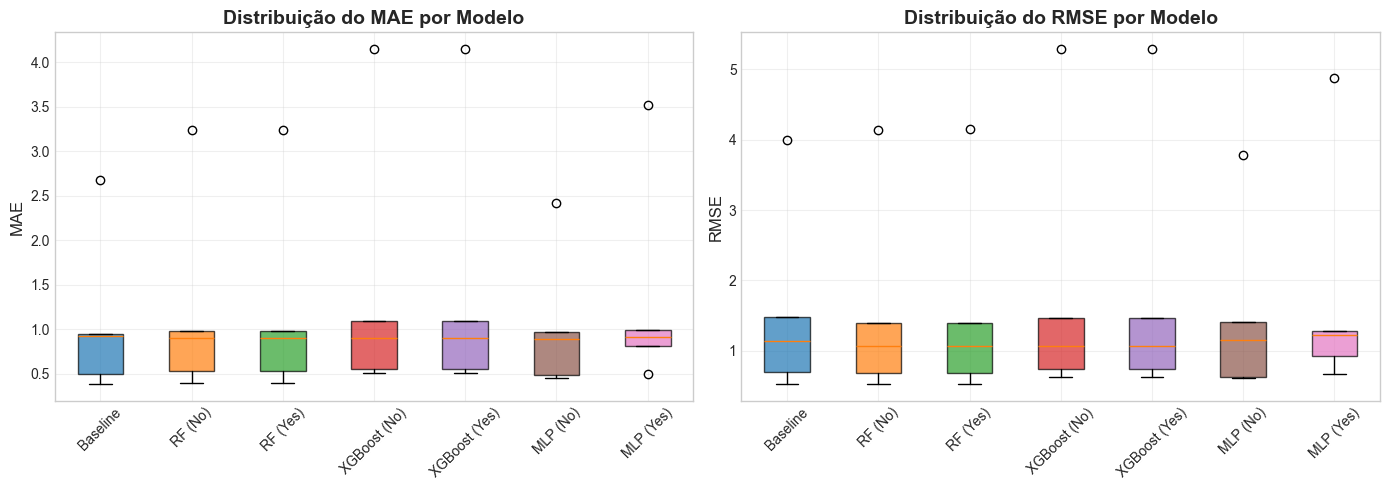

In [73]:
# Visualização: Comparação de MAE por modelo
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Criar label combinado
df_results['model_label'] = df_results['model'] + ' (' + df_results['normalized'].astype(str) + ')'

# Boxplot MAE
ax1 = axes[0]
model_labels = df_results['model_label'].unique()
data_mae = [df_results[df_results['model_label'] == m]['MAE'].values for m in model_labels]
bp1 = ax1.boxplot(data_mae, labels=[m.replace(' (N/A)', '') for m in model_labels], patch_artist=True)
for i, patch in enumerate(bp1['boxes']):
    patch.set_facecolor(COLORS[i % len(COLORS)])
    patch.set_alpha(0.7)
ax1.set_ylabel('MAE', fontsize=12)
ax1.set_title('Distribuição do MAE por Modelo', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Boxplot RMSE
ax2 = axes[1]
data_rmse = [df_results[df_results['model_label'] == m]['RMSE'].values for m in model_labels]
bp2 = ax2.boxplot(data_rmse, labels=[m.replace(' (N/A)', '') for m in model_labels], patch_artist=True)
for i, patch in enumerate(bp2['boxes']):
    patch.set_facecolor(COLORS[i % len(COLORS)])
    patch.set_alpha(0.7)
ax2.set_ylabel('RMSE', fontsize=12)
ax2.set_title('Distribuição do RMSE por Modelo', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

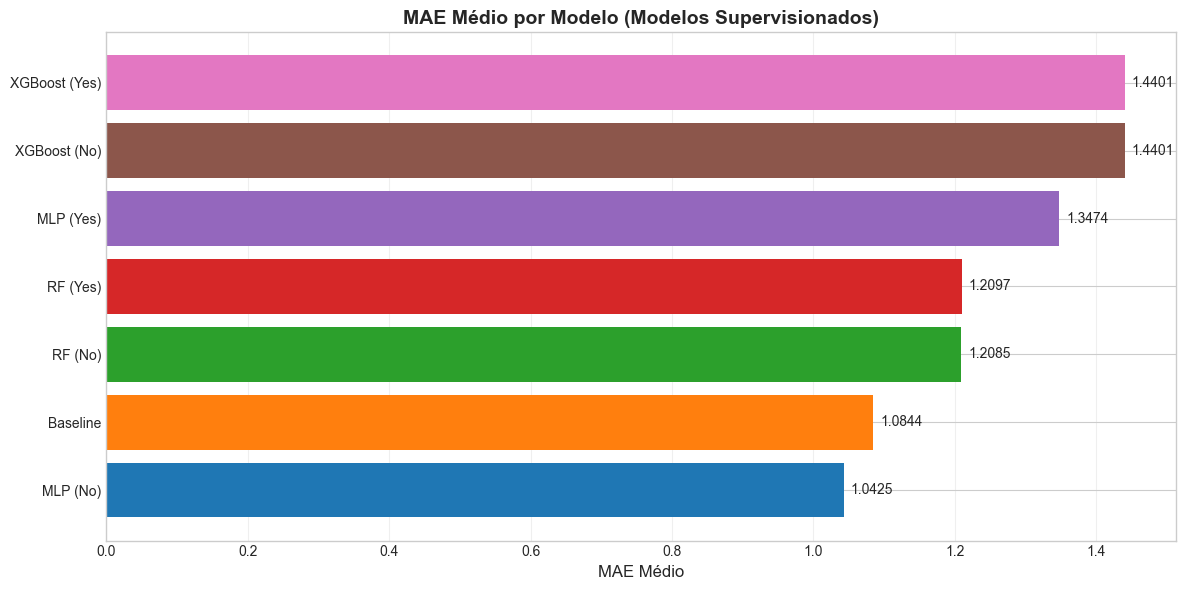

In [74]:
# Gráfico de barras: MAE médio por modelo
fig, ax = plt.subplots(figsize=(12, 6))

mae_by_model = df_results.groupby('model_label')['MAE'].mean().sort_values()

bars = ax.barh(range(len(mae_by_model)), mae_by_model.values, color=COLORS[:len(mae_by_model)])
ax.set_yticks(range(len(mae_by_model)))
ax.set_yticklabels([m.replace(' (N/A)', '') for m in mae_by_model.index])
ax.set_xlabel('MAE Médio', fontsize=12)
ax.set_title('MAE Médio por Modelo (Modelos Supervisionados)', fontsize=14, fontweight='bold')

# Adicionar valores nas barras
for i, (bar, val) in enumerate(zip(bars, mae_by_model.values)):
    ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.4f}', 
            va='center', fontsize=10)

ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 11. Comparação com Modelos de Séries Temporais

In [75]:
# Carregar resultados do notebook 04
print("Comparação com modelos de séries temporais (notebook 04):")
print("=" * 80)

# Resultados de séries temporais
print("\nMétricas médias - Séries Temporais (ARIMA/LSTM):")
ts_stats = df_ts_results.groupby('model')['MAE'].agg(['mean', 'std']).round(4)
print(ts_stats)

# Resultados de modelos supervisionados (melhor versão de cada)
print("\nMétricas médias - Modelos Supervisionados:")
sup_stats = df_results.groupby(['model', 'normalized'])['MAE'].agg(['mean', 'std']).round(4)
print(sup_stats)

Comparação com modelos de séries temporais (notebook 04):

Métricas médias - Séries Temporais (ARIMA/LSTM):
           mean    std
model                 
ARIMA    0.9083 0.7696
Baseline 1.1670 0.8732
LSTM     1.0801 1.0406

Métricas médias - Modelos Supervisionados:
                      mean    std
model    normalized              
Baseline N/A        1.0844 0.9239
MLP      No         1.0425 0.8030
         Yes        1.3474 1.2286
RF       No         1.2085 1.1593
         Yes        1.2097 1.1618
XGBoost  No         1.4401 1.5323
         Yes        1.4401 1.5323


In [76]:
# Nota: As métricas não são diretamente comparáveis porque:
# - Séries temporais: previsão ponto-a-ponto (cada 15 min)
# - Modelos supervisionados: previsão do consumo médio semanal

print("\n⚠️ NOTA IMPORTANTE:")
print("="*60)
print("As métricas dos dois tipos de modelos não são diretamente")
print("comparáveis porque:")
print("")
print("📈 Séries Temporais (ARIMA/LSTM):")
print("   - Target: valor de PotActiva a cada 15 minutos")
print("   - Granularidade: ponto-a-ponto")
print("")
print("📊 Modelos Supervisionados (RF/XGB/MLP):")
print("   - Target: consumo MÉDIO da semana seguinte")
print("   - Granularidade: agregação semanal")
print("")
print("A comparação justa seria usar o mesmo target em ambos.")


⚠️ NOTA IMPORTANTE:
As métricas dos dois tipos de modelos não são diretamente
comparáveis porque:

📈 Séries Temporais (ARIMA/LSTM):
   - Target: valor de PotActiva a cada 15 minutos
   - Granularidade: ponto-a-ponto

📊 Modelos Supervisionados (RF/XGB/MLP):
   - Target: consumo MÉDIO da semana seguinte
   - Granularidade: agregação semanal

A comparação justa seria usar o mesmo target em ambos.


## 12. Impacto da Normalização

In [77]:
# Comparar impacto da normalização por modelo
print("Impacto da Normalização:")
print("=" * 70)

for model in ['RF', 'XGBoost', 'MLP']:
    df_model = df_results[df_results['model'] == model]
    
    if len(df_model) == 0:
        continue
    
    mae_no = df_model[df_model['normalized'] == 'No']['MAE'].mean()
    mae_yes = df_model[df_model['normalized'] == 'Yes']['MAE'].mean()
    
    diff = mae_yes - mae_no
    diff_pct = (diff / mae_no) * 100 if mae_no > 0 else 0
    
    print(f"\n{model}:")
    print(f"  Sem normalização: MAE = {mae_no:.4f}")
    print(f"  Com normalização: MAE = {mae_yes:.4f}")
    print(f"  Diferença: {diff:+.4f} ({diff_pct:+.1f}%)")
    
    if diff < 0:
        print(f"  → Normalização MELHORA o desempenho")
    elif diff > 0:
        print(f"  → Normalização PIORA o desempenho")
    else:
        print(f"  → Sem impacto significativo")

Impacto da Normalização:

RF:
  Sem normalização: MAE = 1.2085
  Com normalização: MAE = 1.2097
  Diferença: +0.0012 (+0.1%)
  → Normalização PIORA o desempenho

XGBoost:
  Sem normalização: MAE = 1.4401
  Com normalização: MAE = 1.4401
  Diferença: +0.0000 (+0.0%)
  → Sem impacto significativo

MLP:
  Sem normalização: MAE = 1.0425
  Com normalização: MAE = 1.3474
  Diferença: +0.3049 (+29.2%)
  → Normalização PIORA o desempenho


## 13. Guardar Resultados

In [78]:
# Guardar resultados
output_path = 'data/intermediate/d4maia_feature_models_results.csv'
df_results.to_csv(output_path, index=False)

print(f"\n✓ Ficheiro guardado: {output_path}")
print(f"\nConteúdo:")
print(df_results.to_string(index=False))


✓ Ficheiro guardado: data/intermediate/d4maia_feature_models_results.csv

Conteúdo:
                 CPE    model normalized    MAE   RMSE    MAPE  n_test    model_label
PT0002000068856781NM Baseline        N/A 0.3862 0.5297  1.2676      35 Baseline (N/A)
PT0002000068856906VS Baseline        N/A 0.9196 1.1354 16.1260      35 Baseline (N/A)
PT0002000081997398TD Baseline        N/A 2.6758 3.9958  8.3158      35 Baseline (N/A)
PT0002000073231742VK Baseline        N/A 0.4946 0.7018 10.7034      35 Baseline (N/A)
PT0002000033074862LZ Baseline        N/A 0.9458 1.4758 13.9696      35 Baseline (N/A)
PT0002000068856781NM       RF         No 0.3974 0.5258  1.3087      35        RF (No)
PT0002000068856906VS       RF         No 0.8993 1.0711 16.2958      35        RF (No)
PT0002000081997398TD       RF         No 3.2351 4.1388 10.5530      35        RF (No)
PT0002000073231742VK       RF         No 0.5265 0.6764 11.4146      35        RF (No)
PT0002000033074862LZ       RF         No 0.9843 1.3914 

## 14. Resumo e Conclusões

In [79]:
print("=" * 80)
print("RESUMO - MODELOS SUPERVISIONADOS COM FEATURES")
print("=" * 80)

print(f"\n📊 DADOS:")
print(f"   • CPEs analisados: {len(selected_cpes)}")
print(f"   • Features criadas: {len(feature_cols)}")
print(f"   • Target: consumo médio semanal")

print(f"\n📈 MODELOS IMPLEMENTADOS:")
print(f"   • Baseline (média semana anterior)")
print(f"   • Random Forest (com e sem normalização)")
print(f"   • XGBoost (com e sem normalização)")
print(f"   • MLP (com e sem normalização)")

# Encontrar melhor modelo
best_row = df_results.loc[df_results['MAE'].idxmin()]
print(f"\n🏆 MELHOR MODELO:")
print(f"   • {best_row['model']} (normalizado: {best_row['normalized']})")
print(f"   • MAE: {best_row['MAE']:.4f}")
print(f"   • RMSE: {best_row['RMSE']:.4f}")

# Comparar com baseline
baseline_mae = df_results[df_results['model'] == 'Baseline']['MAE'].mean()
best_mae = df_results.groupby(['model', 'normalized'])['MAE'].mean().min()
improvement = (baseline_mae - best_mae) / baseline_mae * 100

print(f"\n📉 COMPARAÇÃO COM BASELINE:")
print(f"   • MAE Baseline: {baseline_mae:.4f}")
print(f"   • MAE Melhor Modelo: {best_mae:.4f}")
print(f"   • Melhoria: {improvement:.1f}%")

print(f"\n📁 FICHEIRO GERADO:")
print(f"   • data/intermediate/d4maia_feature_models_results.csv")

RESUMO - MODELOS SUPERVISIONADOS COM FEATURES

📊 DADOS:
   • CPEs analisados: 5
   • Features criadas: 28
   • Target: consumo médio semanal

📈 MODELOS IMPLEMENTADOS:
   • Baseline (média semana anterior)
   • Random Forest (com e sem normalização)
   • XGBoost (com e sem normalização)
   • MLP (com e sem normalização)

🏆 MELHOR MODELO:
   • Baseline (normalizado: N/A)
   • MAE: 0.3862
   • RMSE: 0.5297

📉 COMPARAÇÃO COM BASELINE:
   • MAE Baseline: 1.0844
   • MAE Melhor Modelo: 1.0425
   • Melhoria: 3.9%

📁 FICHEIRO GERADO:
   • data/intermediate/d4maia_feature_models_results.csv


In [80]:
print("\n" + "=" * 80)
print("Notebook de Modelos Supervisionados concluído!")
print("=" * 80)
print("\n💡 PRÓXIMOS PASSOS:")
print("   1. Comparações finais e avaliação - notebook 06")
print("   2. Relatório final em PDF")


Notebook de Modelos Supervisionados concluído!

💡 PRÓXIMOS PASSOS:
   1. Comparações finais e avaliação - notebook 06
   2. Relatório final em PDF
